In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import scipy.spatial.distance
import scipy
import pandas as pd

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

plt.set_cmap('gray')

<Figure size 432x288 with 0 Axes>

In [0]:
def data_preparation():
  #Trainings- und Testdaten
  global digits_train, labels_train
  mnist_train = tf.keras.datasets.mnist.load_data()[0]
  digits_train, labels_train = mnist_train[0], mnist_train[1]

  global digits_test, labels_test
  mnist_test = tf.keras.datasets.mnist.load_data()[1]
  digits_test, labels_test = mnist_test[0], mnist_test[1]
  
  #Anzahl der Samples in train und test
  global n_train
  n_train = digits_train.shape[0]
  n_test = digits_test.shape[0]

  #Anzahl der Pixel
  m = digits_train.shape[1]**2

  #Vektor aus Matrizen erstellen -> digits flat
  global digits_train_flat, digits_test_flat
  digits_train_flat = digits_train.reshape([n_train, m])
  digits_test_flat = digits_test.reshape([n_test, m])

  #Subsamples der unserer Datensätze
  idx = np.random.randint(n_train, size = 5000)
  global digits_train_sample, labels_train_sample
  digits_train_sample = digits_train_flat[idx]
  labels_train_sample = labels_train[idx]

  global digits_test_sample, labels_test_sample, digits_test_sample_n_flat
  idx = np.random.randint(n_test, size = 300)
  digits_test_sample_n_flat = digits_test[idx]
  digits_test_sample = digits_test_flat[idx]
  labels_test_sample = labels_test[idx]

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
def logReg(solver_mode):
  #n_jobs für alle solver außer liblinear
  lr = LogisticRegression(solver=solver_mode, max_iter=1000, n_jobs=-1).fit(digits_train_sample, labels_train_sample)
  #print("Score: ", lr.score(digits_train_sample, labels_train_sample))
  logReg_result = lr.predict(digits_test_sample)

  return logReg_result

In [0]:
def calc_error(knn_result):
  n_error = 0
  check_matrix = labels_test_sample == knn_result
  for check_bool in check_matrix:
    if check_bool == False:
      n_error = n_error + 1
  error_rate = n_error / len(knn_result) * 100
  print("Errorrate: ", error_rate, "%")
  print("F1 Score: ", f1_score(labels_test_sample, logReg_result, average="micro"))
  print("Errorrate durch F1 überprüfen: ", (1-(f1_score(labels_test_sample, logReg_result, average="micro"))))
  error = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
  total ={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0}
  global error_array
  error_array = []
  for i in range(len(labels_test_sample)):
    if labels_test_sample[i] != knn_result[i]:
      error[labels_test_sample[i]] +=1
      total[labels_test_sample[i]] +=1
      error_array.append(i)
    else:
      total[labels_test_sample[i]] +=1
  
  errorrate = {}
  for i in range(0,10):
    errorrate[i] = (error[i] / total[i]) * 100
    print("Errorrate für", i, " = ", round(errorrate[i], 2), "%")
  #print(pd.DataFrame([error]))
  #print(pd.DataFrame([total]))
  print("Index der Fehler im Sampleset: ",error_array)
  
  print("")
  #Alle Bilder anzeigen die falsch zugeordnet wurden
  for i in range(len(error_array)):
    print("Bild Nr.", i+1)
    print("Richtiges Label", labels_test_sample[error_array[i]])
    print("Knn Label Ergebnis:", knn_result[error_array[i]])
    plt.imshow(digits_test_sample_n_flat[error_array[i]])
    plt.show()
  plot_confusion_matrix(labels_test_sample, knn_result, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# **Verschiedene solver testen**

**Knn Label Ergebnis müsste Logistic Regression Ergebnis heißen**

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Errorrate:  14.333333333333334 %
F1 Score:  0.8566666666666667
Errorrate durch F1 überprüfen:  0.1433333333333333
Errorrate für 0  =  10.0 %
Errorrate für 1  =  2.86 %
Errorrate für 2  =  34.62 %
Errorrate für 3  =  18.18 %
Errorrate für 4  =  10.34 %
Errorrate für 5  =  14.71 %
Errorrate für 6  =  8.82 %
Errorrate für 7  =  12.9 %
Errorrate für 8  =  20.0 %
Errorrate für 9  =  17.39 %
Index der Fehler im Sampleset:  [5, 26, 33, 37, 38, 46, 53, 60, 61, 62, 72, 73, 81, 95, 107, 122, 133, 134, 141, 156, 157, 168, 169, 175, 187, 191, 207, 209, 214, 219, 221, 224, 228, 234, 247, 254, 256, 260, 264, 273, 278, 284, 285]

Bild Nr. 1
Richtiges Label 1
Knn Label Ergebnis: 3


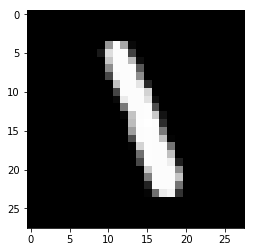

Bild Nr. 2
Richtiges Label 9
Knn Label Ergebnis: 7


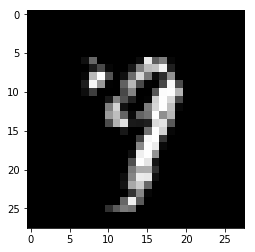

Bild Nr. 3
Richtiges Label 2
Knn Label Ergebnis: 8


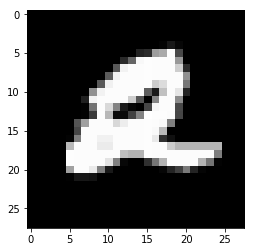

Bild Nr. 4
Richtiges Label 0
Knn Label Ergebnis: 9


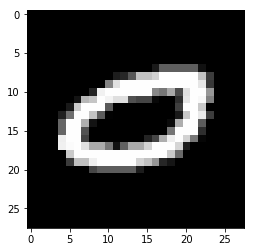

Bild Nr. 5
Richtiges Label 6
Knn Label Ergebnis: 3


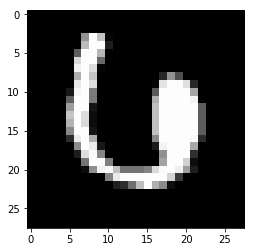

Bild Nr. 6
Richtiges Label 2
Knn Label Ergebnis: 0


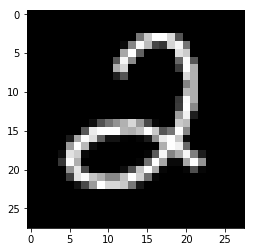

Bild Nr. 7
Richtiges Label 0
Knn Label Ergebnis: 9


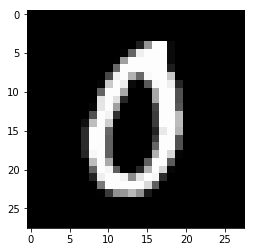

Bild Nr. 8
Richtiges Label 7
Knn Label Ergebnis: 9


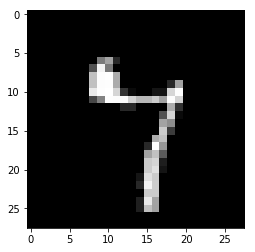

Bild Nr. 9
Richtiges Label 7
Knn Label Ergebnis: 9


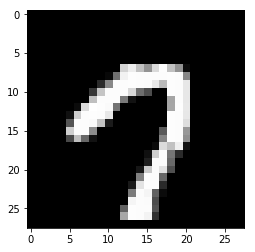

Bild Nr. 10
Richtiges Label 2
Knn Label Ergebnis: 7


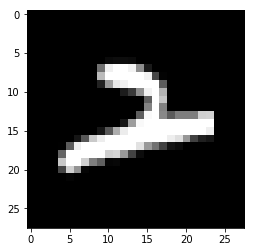

Bild Nr. 11
Richtiges Label 2
Knn Label Ergebnis: 8


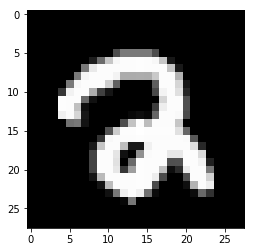

Bild Nr. 12
Richtiges Label 6
Knn Label Ergebnis: 4


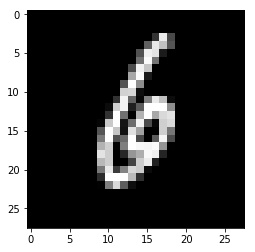

Bild Nr. 13
Richtiges Label 9
Knn Label Ergebnis: 4


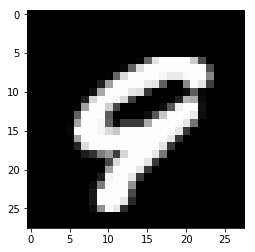

Bild Nr. 14
Richtiges Label 2
Knn Label Ergebnis: 3


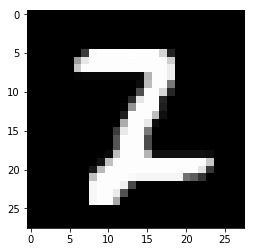

Bild Nr. 15
Richtiges Label 2
Knn Label Ergebnis: 8


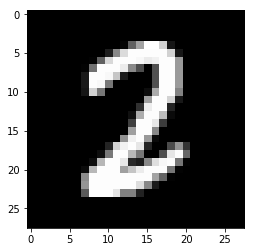

Bild Nr. 16
Richtiges Label 8
Knn Label Ergebnis: 4


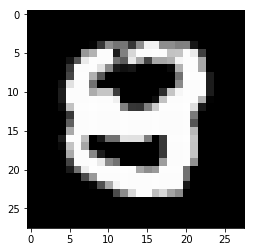

Bild Nr. 17
Richtiges Label 3
Knn Label Ergebnis: 2


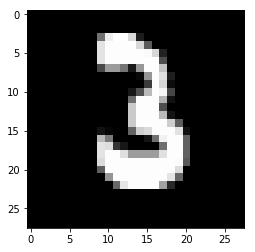

Bild Nr. 18
Richtiges Label 7
Knn Label Ergebnis: 9


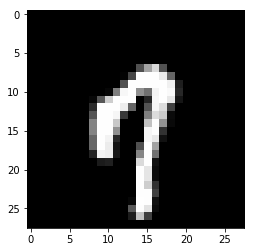

Bild Nr. 19
Richtiges Label 2
Knn Label Ergebnis: 6


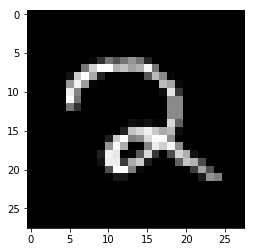

Bild Nr. 20
Richtiges Label 5
Knn Label Ergebnis: 4


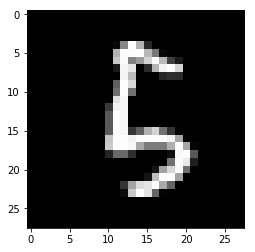

Bild Nr. 21
Richtiges Label 4
Knn Label Ergebnis: 9


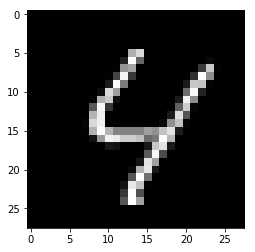

Bild Nr. 22
Richtiges Label 8
Knn Label Ergebnis: 9


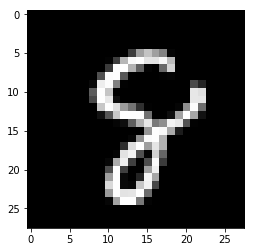

Bild Nr. 23
Richtiges Label 4
Knn Label Ergebnis: 5


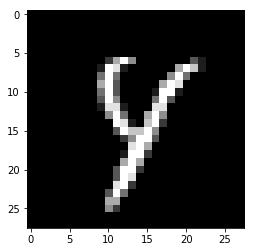

Bild Nr. 24
Richtiges Label 7
Knn Label Ergebnis: 9


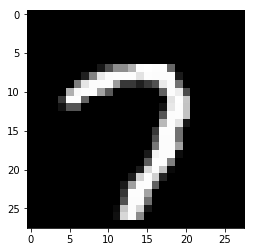

Bild Nr. 25
Richtiges Label 5
Knn Label Ergebnis: 8


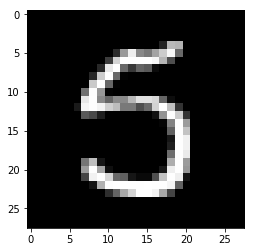

Bild Nr. 26
Richtiges Label 3
Knn Label Ergebnis: 5


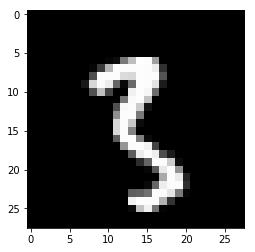

Bild Nr. 27
Richtiges Label 5
Knn Label Ergebnis: 9


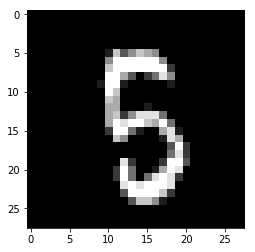

Bild Nr. 28
Richtiges Label 0
Knn Label Ergebnis: 9


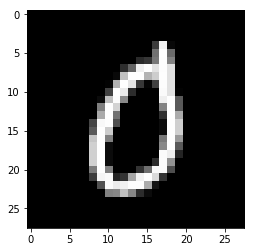

Bild Nr. 29
Richtiges Label 5
Knn Label Ergebnis: 3


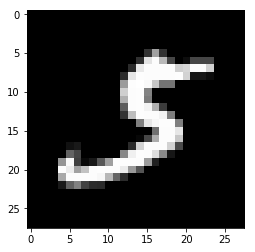

Bild Nr. 30
Richtiges Label 8
Knn Label Ergebnis: 3


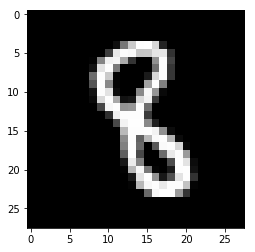

Bild Nr. 31
Richtiges Label 3
Knn Label Ergebnis: 2


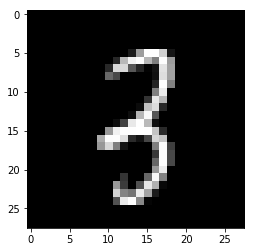

Bild Nr. 32
Richtiges Label 3
Knn Label Ergebnis: 5


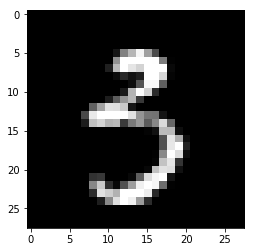

Bild Nr. 33
Richtiges Label 3
Knn Label Ergebnis: 2


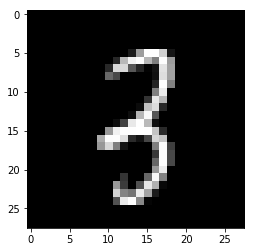

Bild Nr. 34
Richtiges Label 6
Knn Label Ergebnis: 5


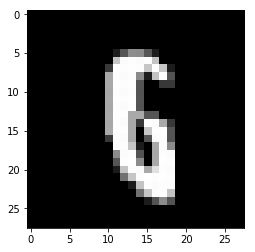

Bild Nr. 35
Richtiges Label 8
Knn Label Ergebnis: 5


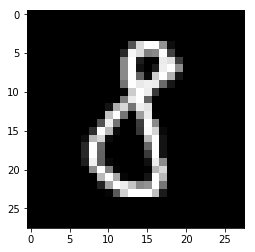

Bild Nr. 36
Richtiges Label 9
Knn Label Ergebnis: 8


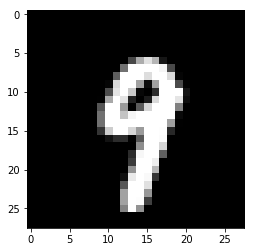

Bild Nr. 37
Richtiges Label 3
Knn Label Ergebnis: 8


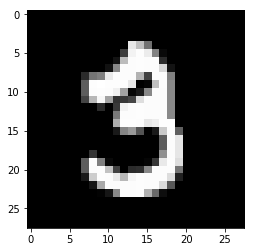

Bild Nr. 38
Richtiges Label 4
Knn Label Ergebnis: 9


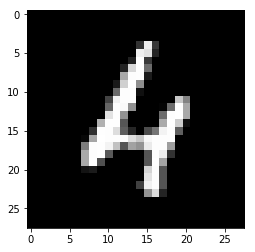

Bild Nr. 39
Richtiges Label 8
Knn Label Ergebnis: 9


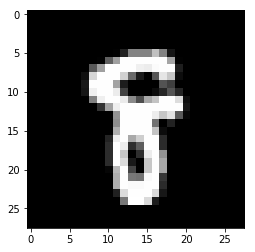

Bild Nr. 40
Richtiges Label 2
Knn Label Ergebnis: 7


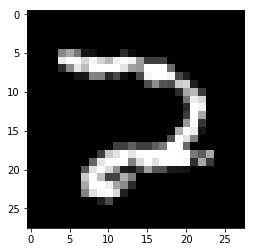

Bild Nr. 41
Richtiges Label 2
Knn Label Ergebnis: 9


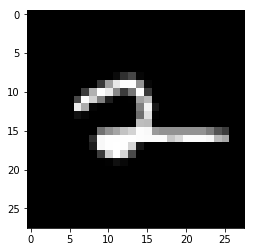

Bild Nr. 42
Richtiges Label 9
Knn Label Ergebnis: 8


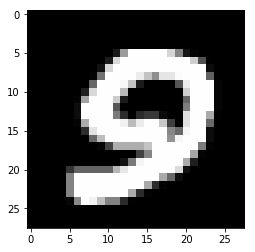

Bild Nr. 43
Richtiges Label 5
Knn Label Ergebnis: 6


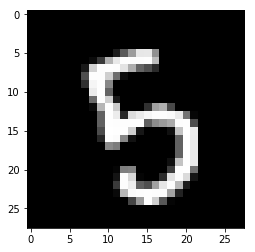

Confusion matrix, without normalization
[[27  0  0  0  0  0  0  0  0  3]
 [ 0 34  0  1  0  0  0  0  0  0]
 [ 1  0 17  1  0  0  1  2  3  1]
 [ 0  0  3 27  0  2  0  0  1  0]
 [ 0  0  0  0 26  1  0  0  0  2]
 [ 0  0  0  1  1 29  1  0  1  1]
 [ 0  0  0  1  1  1 31  0  0  0]
 [ 0  0  0  0  0  0  0 27  0  4]
 [ 0  0  0  1  1  1  0  0 20  2]
 [ 0  0  0  0  1  0  0  1  2 19]]


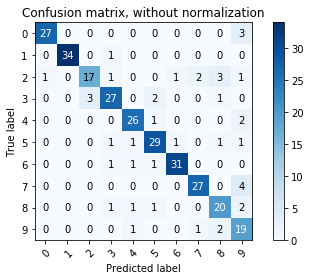

In [0]:
data_preparation()
logReg_result = logReg("liblinear")
calc_error(logReg_result)

**Knn Label Ergebnis müsste Logistic Regression Ergebnis heißen**

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Errorrate:  11.333333333333332 %
F1 Score:  0.8866666666666667
Errorrate durch F1 überprüfen:  0.11333333333333329
Errorrate für 0  =  3.33 %
Errorrate für 1  =  2.86 %
Errorrate für 2  =  26.92 %
Errorrate für 3  =  18.18 %
Errorrate für 4  =  3.45 %
Errorrate für 5  =  14.71 %
Errorrate für 6  =  11.76 %
Errorrate für 7  =  3.23 %
Errorrate für 8  =  16.0 %
Errorrate für 9  =  17.39 %
Index der Fehler im Sampleset:  [24, 26, 37, 38, 46, 62, 65, 73, 81, 95, 107, 122, 133, 134, 156, 162, 187, 191, 207, 214, 219, 221, 224, 228, 234, 247, 256, 257, 260, 273, 278, 284, 285, 295]

Bild Nr. 1
Richtiges Label 1
Knn Label Ergebnis: 8


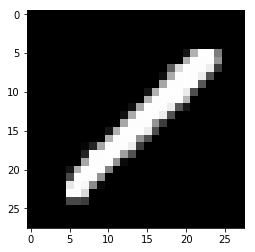

Bild Nr. 2
Richtiges Label 9
Knn Label Ergebnis: 7


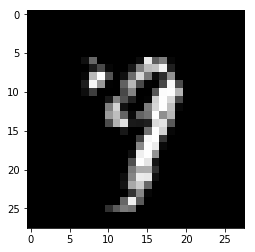

Bild Nr. 3
Richtiges Label 0
Knn Label Ergebnis: 7


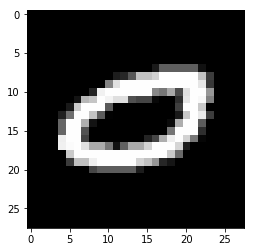

Bild Nr. 4
Richtiges Label 6
Knn Label Ergebnis: 0


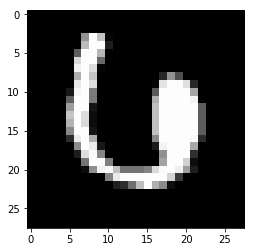

Bild Nr. 5
Richtiges Label 2
Knn Label Ergebnis: 3


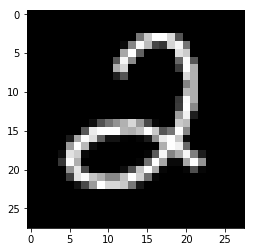

Bild Nr. 6
Richtiges Label 2
Knn Label Ergebnis: 7


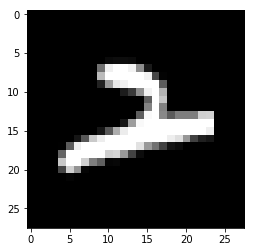

Bild Nr. 7
Richtiges Label 2
Knn Label Ergebnis: 8


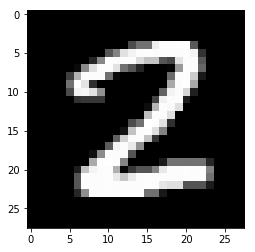

Bild Nr. 8
Richtiges Label 6
Knn Label Ergebnis: 4


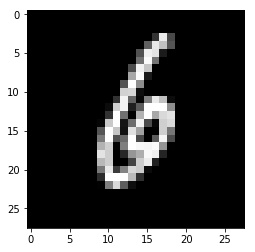

Bild Nr. 9
Richtiges Label 9
Knn Label Ergebnis: 4


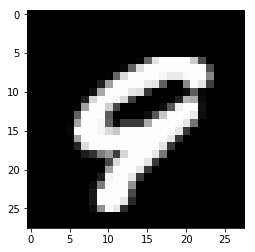

Bild Nr. 10
Richtiges Label 2
Knn Label Ergebnis: 3


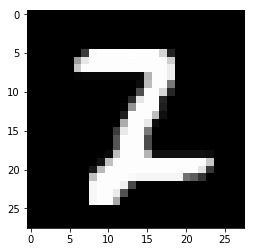

Bild Nr. 11
Richtiges Label 2
Knn Label Ergebnis: 8


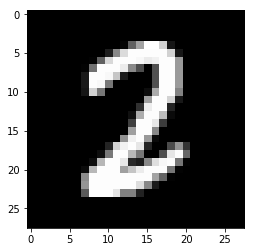

Bild Nr. 12
Richtiges Label 8
Knn Label Ergebnis: 3


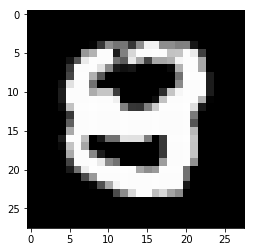

Bild Nr. 13
Richtiges Label 3
Knn Label Ergebnis: 2


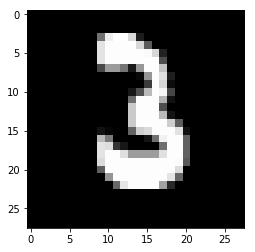

Bild Nr. 14
Richtiges Label 7
Knn Label Ergebnis: 9


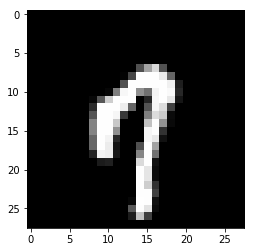

Bild Nr. 15
Richtiges Label 5
Knn Label Ergebnis: 8


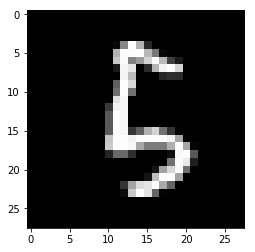

Bild Nr. 16
Richtiges Label 9
Knn Label Ergebnis: 4


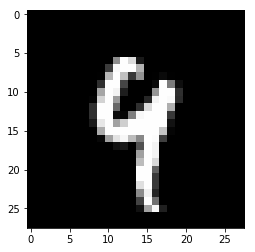

Bild Nr. 17
Richtiges Label 5
Knn Label Ergebnis: 8


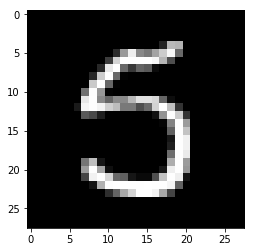

Bild Nr. 18
Richtiges Label 3
Knn Label Ergebnis: 5


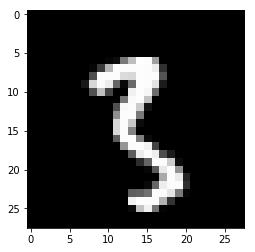

Bild Nr. 19
Richtiges Label 5
Knn Label Ergebnis: 9


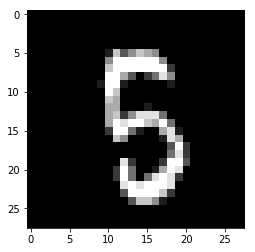

Bild Nr. 20
Richtiges Label 5
Knn Label Ergebnis: 3


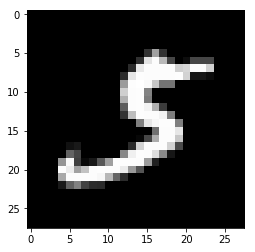

Bild Nr. 21
Richtiges Label 8
Knn Label Ergebnis: 3


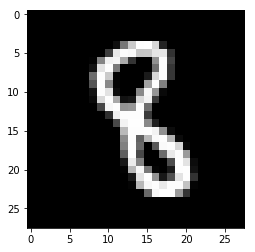

Bild Nr. 22
Richtiges Label 3
Knn Label Ergebnis: 2


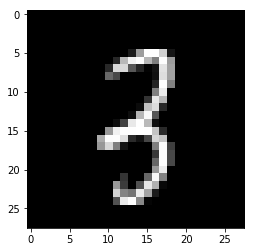

Bild Nr. 23
Richtiges Label 3
Knn Label Ergebnis: 5


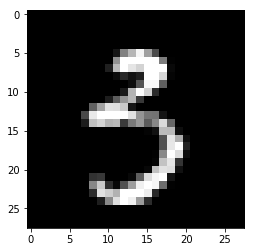

Bild Nr. 24
Richtiges Label 3
Knn Label Ergebnis: 2


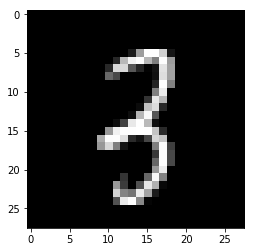

Bild Nr. 25
Richtiges Label 6
Knn Label Ergebnis: 5


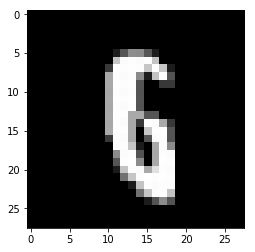

Bild Nr. 26
Richtiges Label 8
Knn Label Ergebnis: 5


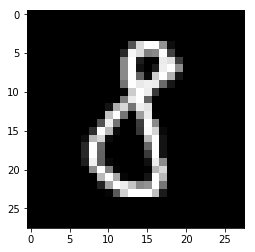

Bild Nr. 27
Richtiges Label 3
Knn Label Ergebnis: 8


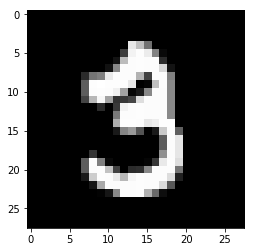

Bild Nr. 28
Richtiges Label 8
Knn Label Ergebnis: 1


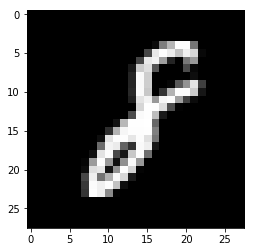

Bild Nr. 29
Richtiges Label 4
Knn Label Ergebnis: 9


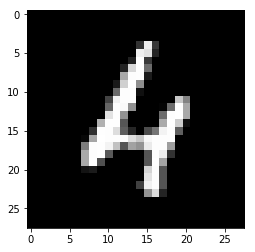

Bild Nr. 30
Richtiges Label 2
Knn Label Ergebnis: 7


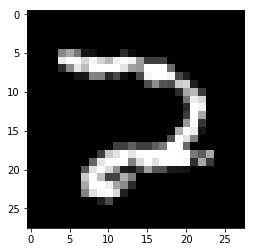

Bild Nr. 31
Richtiges Label 2
Knn Label Ergebnis: 8


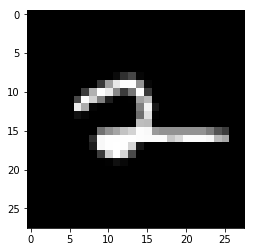

Bild Nr. 32
Richtiges Label 9
Knn Label Ergebnis: 0


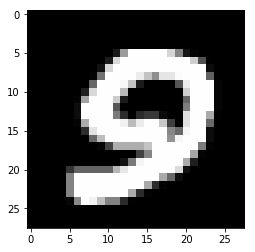

Bild Nr. 33
Richtiges Label 5
Knn Label Ergebnis: 6


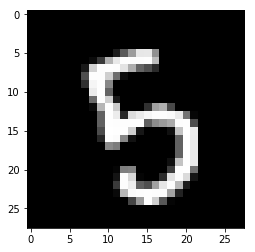

Bild Nr. 34
Richtiges Label 6
Knn Label Ergebnis: 8


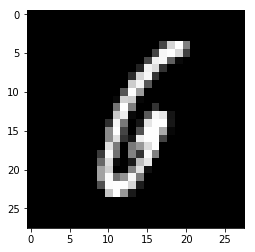

Confusion matrix, without normalization
[[29  0  0  0  0  0  0  1  0  0]
 [ 0 34  0  0  0  0  0  0  1  0]
 [ 0  0 19  2  0  0  0  2  3  0]
 [ 0  0  3 27  0  2  0  0  1  0]
 [ 0  0  0  0 28  0  0  0  0  1]
 [ 0  0  0  1  0 29  1  0  2  1]
 [ 1  0  0  0  1  1 30  0  1  0]
 [ 0  0  0  0  0  0  0 30  0  1]
 [ 0  1  0  2  0  1  0  0 21  0]
 [ 1  0  0  0  2  0  0  1  0 19]]


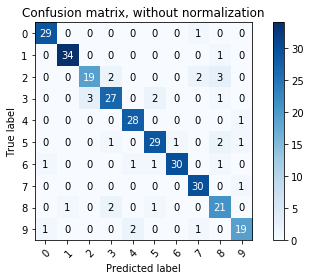

In [0]:
logReg_result = logReg("sag")
calc_error(logReg_result)

**Knn Label Ergebnis müsste Logistic Regression Ergebnis heißen**

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Errorrate:  11.666666666666666 %
F1 Score:  0.8833333333333333
Errorrate durch F1 überprüfen:  0.1166666666666667
Errorrate für 0  =  3.33 %
Errorrate für 1  =  2.86 %
Errorrate für 2  =  30.77 %
Errorrate für 3  =  15.15 %
Errorrate für 4  =  3.45 %
Errorrate für 5  =  14.71 %
Errorrate für 6  =  11.76 %
Errorrate für 7  =  3.23 %
Errorrate für 8  =  20.0 %
Errorrate für 9  =  17.39 %
Index der Fehler im Sampleset:  [24, 26, 37, 38, 46, 62, 65, 73, 81, 95, 107, 122, 133, 134, 156, 162, 187, 191, 207, 214, 219, 221, 226, 228, 234, 247, 256, 257, 260, 273, 278, 284, 285, 290, 295]

Bild Nr. 1
Richtiges Label 1
Knn Label Ergebnis: 8


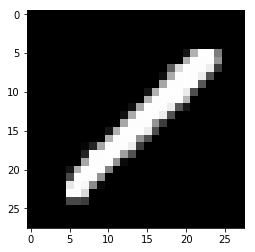

Bild Nr. 2
Richtiges Label 9
Knn Label Ergebnis: 7


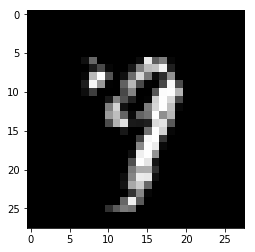

Bild Nr. 3
Richtiges Label 0
Knn Label Ergebnis: 7


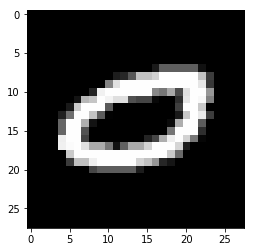

Bild Nr. 4
Richtiges Label 6
Knn Label Ergebnis: 0


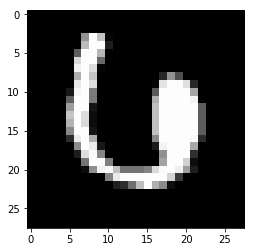

Bild Nr. 5
Richtiges Label 2
Knn Label Ergebnis: 3


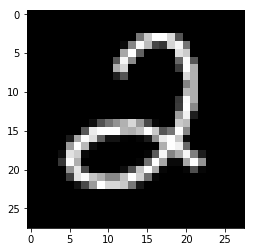

Bild Nr. 6
Richtiges Label 2
Knn Label Ergebnis: 7


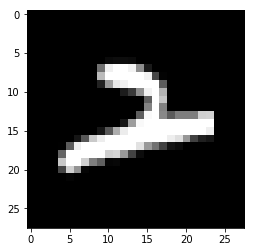

Bild Nr. 7
Richtiges Label 2
Knn Label Ergebnis: 8


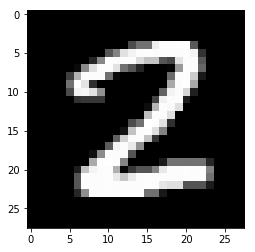

Bild Nr. 8
Richtiges Label 6
Knn Label Ergebnis: 4


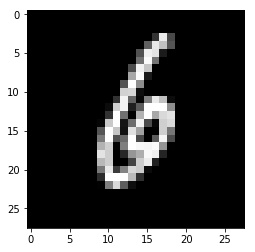

Bild Nr. 9
Richtiges Label 9
Knn Label Ergebnis: 4


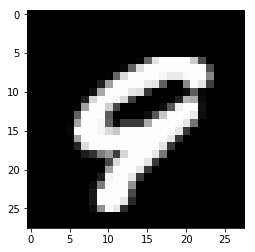

Bild Nr. 10
Richtiges Label 2
Knn Label Ergebnis: 3


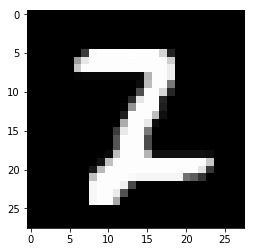

Bild Nr. 11
Richtiges Label 2
Knn Label Ergebnis: 8


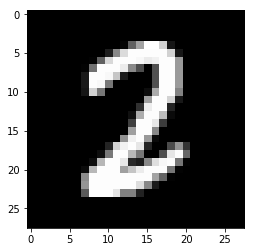

Bild Nr. 12
Richtiges Label 8
Knn Label Ergebnis: 3


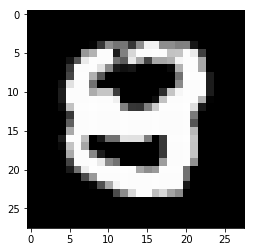

Bild Nr. 13
Richtiges Label 3
Knn Label Ergebnis: 2


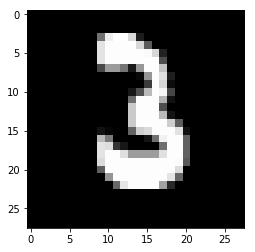

Bild Nr. 14
Richtiges Label 7
Knn Label Ergebnis: 9


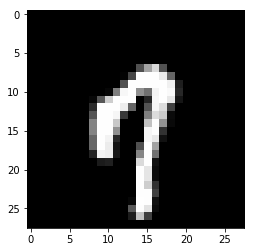

Bild Nr. 15
Richtiges Label 5
Knn Label Ergebnis: 8


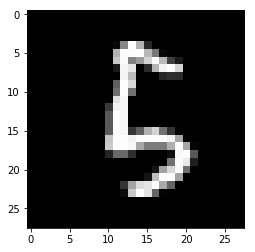

Bild Nr. 16
Richtiges Label 9
Knn Label Ergebnis: 4


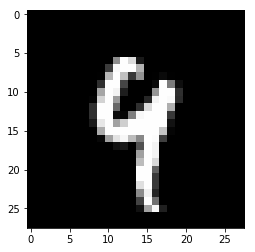

Bild Nr. 17
Richtiges Label 5
Knn Label Ergebnis: 8


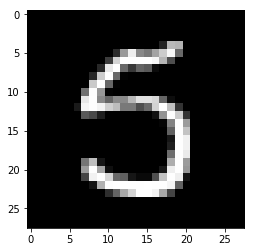

Bild Nr. 18
Richtiges Label 3
Knn Label Ergebnis: 5


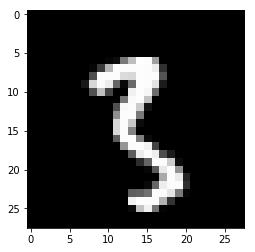

Bild Nr. 19
Richtiges Label 5
Knn Label Ergebnis: 9


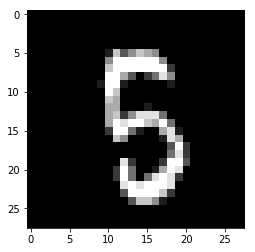

Bild Nr. 20
Richtiges Label 5
Knn Label Ergebnis: 3


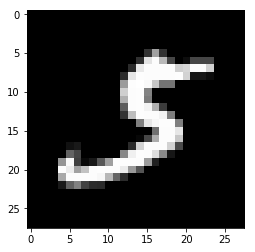

Bild Nr. 21
Richtiges Label 8
Knn Label Ergebnis: 3


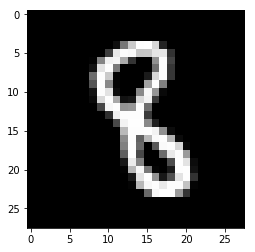

Bild Nr. 22
Richtiges Label 3
Knn Label Ergebnis: 2


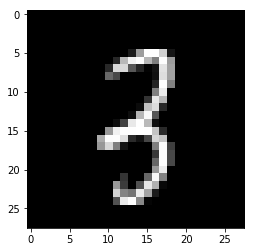

Bild Nr. 23
Richtiges Label 8
Knn Label Ergebnis: 9


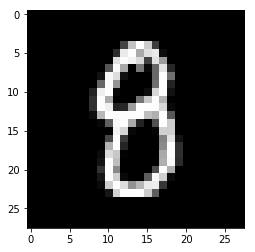

Bild Nr. 24
Richtiges Label 3
Knn Label Ergebnis: 2


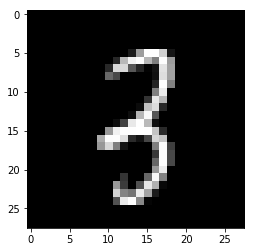

Bild Nr. 25
Richtiges Label 6
Knn Label Ergebnis: 5


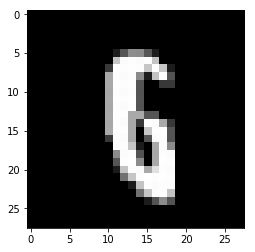

Bild Nr. 26
Richtiges Label 8
Knn Label Ergebnis: 5


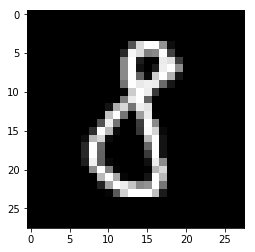

Bild Nr. 27
Richtiges Label 3
Knn Label Ergebnis: 5


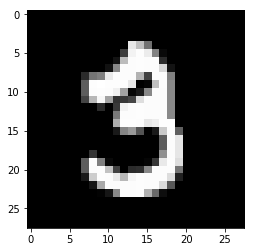

Bild Nr. 28
Richtiges Label 8
Knn Label Ergebnis: 1


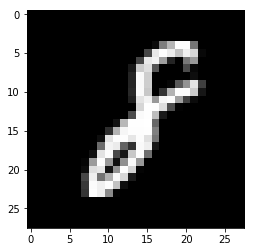

Bild Nr. 29
Richtiges Label 4
Knn Label Ergebnis: 9


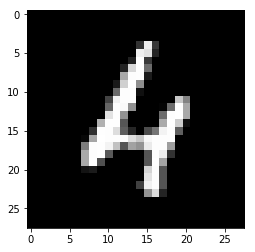

Bild Nr. 30
Richtiges Label 2
Knn Label Ergebnis: 7


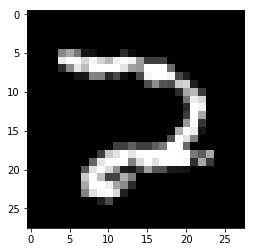

Bild Nr. 31
Richtiges Label 2
Knn Label Ergebnis: 8


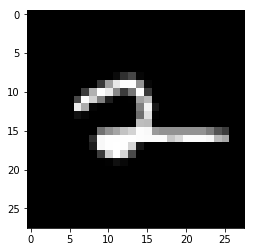

Bild Nr. 32
Richtiges Label 9
Knn Label Ergebnis: 0


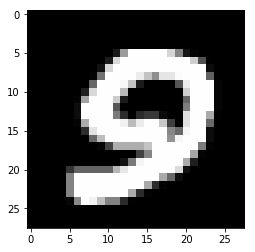

Bild Nr. 33
Richtiges Label 5
Knn Label Ergebnis: 6


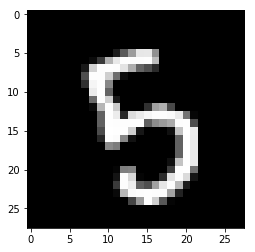

Bild Nr. 34
Richtiges Label 2
Knn Label Ergebnis: 8


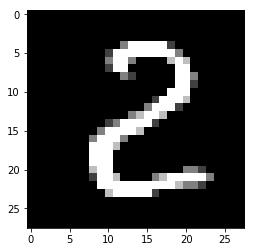

Bild Nr. 35
Richtiges Label 6
Knn Label Ergebnis: 8


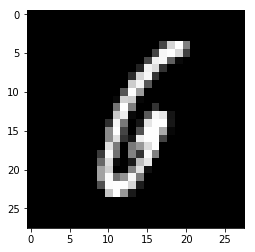

Confusion matrix, without normalization
[[29  0  0  0  0  0  0  1  0  0]
 [ 0 34  0  0  0  0  0  0  1  0]
 [ 0  0 18  2  0  0  0  2  4  0]
 [ 0  0  3 28  0  2  0  0  0  0]
 [ 0  0  0  0 28  0  0  0  0  1]
 [ 0  0  0  1  0 29  1  0  2  1]
 [ 1  0  0  0  1  1 30  0  1  0]
 [ 0  0  0  0  0  0  0 30  0  1]
 [ 0  1  0  2  0  1  0  0 20  1]
 [ 1  0  0  0  2  0  0  1  0 19]]


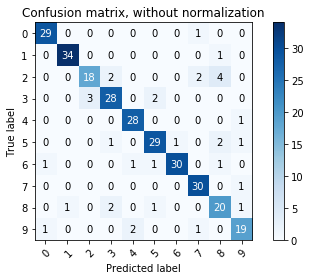

In [0]:
logReg_result = logReg("saga")
calc_error(logReg_result)

**Knn Label Ergebnis müsste Logistic Regression Ergebnis heißen**

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Errorrate:  14.333333333333334 %
F1 Score:  0.8566666666666667
Errorrate durch F1 überprüfen:  0.1433333333333333
Errorrate für 0  =  10.0 %
Errorrate für 1  =  2.86 %
Errorrate für 2  =  23.08 %
Errorrate für 3  =  18.18 %
Errorrate für 4  =  10.34 %
Errorrate für 5  =  20.59 %
Errorrate für 6  =  11.76 %
Errorrate für 7  =  12.9 %
Errorrate für 8  =  20.0 %
Errorrate für 9  =  17.39 %
Index der Fehler im Sampleset:  [5, 9, 26, 33, 37, 38, 53, 60, 61, 62, 73, 74, 81, 95, 107, 114, 122, 133, 134, 142, 156, 169, 175, 187, 191, 207, 209, 214, 219, 221, 224, 228, 234, 247, 254, 256, 260, 264, 273, 278, 284, 285, 295]

Bild Nr. 1
Richtiges Label 1
Knn Label Ergebnis: 3


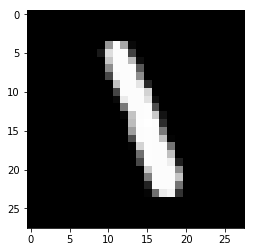

Bild Nr. 2
Richtiges Label 4
Knn Label Ergebnis: 9


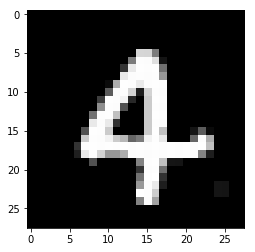

Bild Nr. 3
Richtiges Label 9
Knn Label Ergebnis: 7


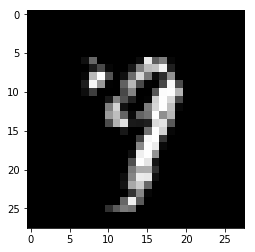

Bild Nr. 4
Richtiges Label 2
Knn Label Ergebnis: 8


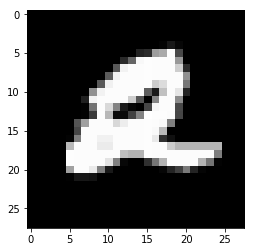

Bild Nr. 5
Richtiges Label 0
Knn Label Ergebnis: 9


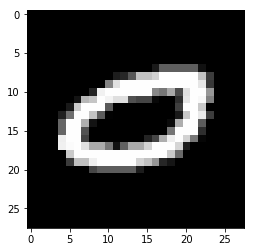

Bild Nr. 6
Richtiges Label 6
Knn Label Ergebnis: 3


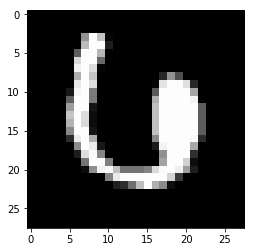

Bild Nr. 7
Richtiges Label 0
Knn Label Ergebnis: 9


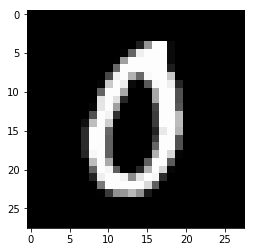

Bild Nr. 8
Richtiges Label 7
Knn Label Ergebnis: 9


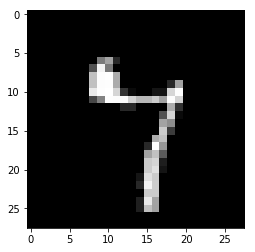

Bild Nr. 9
Richtiges Label 7
Knn Label Ergebnis: 9


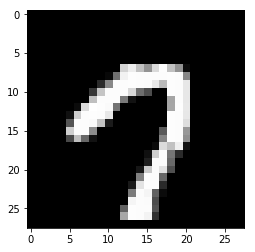

Bild Nr. 10
Richtiges Label 2
Knn Label Ergebnis: 7


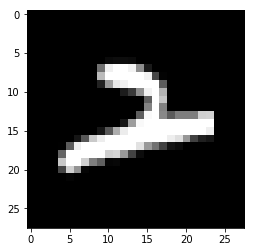

Bild Nr. 11
Richtiges Label 6
Knn Label Ergebnis: 4


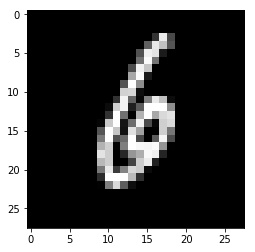

Bild Nr. 12
Richtiges Label 5
Knn Label Ergebnis: 8


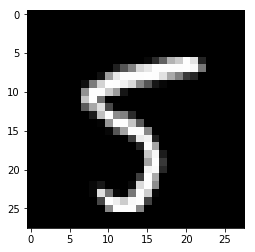

Bild Nr. 13
Richtiges Label 9
Knn Label Ergebnis: 4


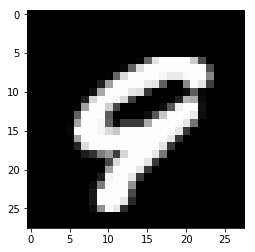

Bild Nr. 14
Richtiges Label 2
Knn Label Ergebnis: 3


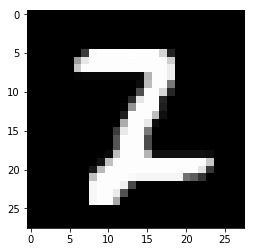

Bild Nr. 15
Richtiges Label 2
Knn Label Ergebnis: 8


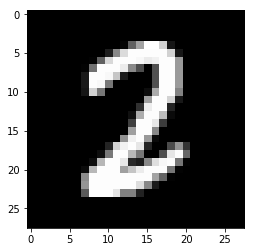

Bild Nr. 16
Richtiges Label 5
Knn Label Ergebnis: 8


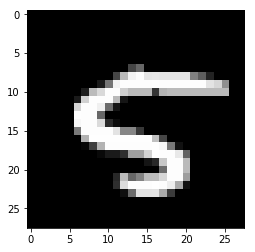

Bild Nr. 17
Richtiges Label 8
Knn Label Ergebnis: 6


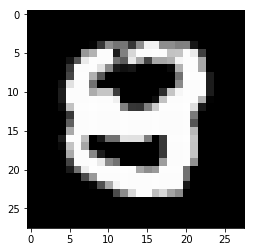

Bild Nr. 18
Richtiges Label 3
Knn Label Ergebnis: 2


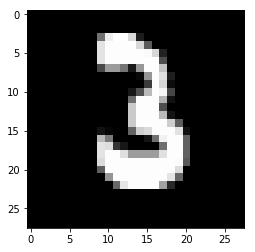

Bild Nr. 19
Richtiges Label 7
Knn Label Ergebnis: 9


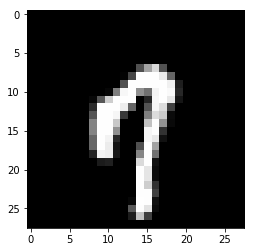

Bild Nr. 20
Richtiges Label 8
Knn Label Ergebnis: 9


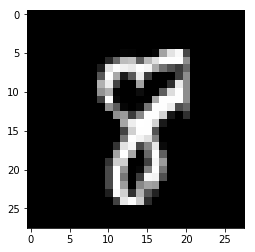

Bild Nr. 21
Richtiges Label 5
Knn Label Ergebnis: 8


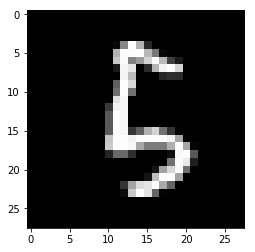

Bild Nr. 22
Richtiges Label 4
Knn Label Ergebnis: 5


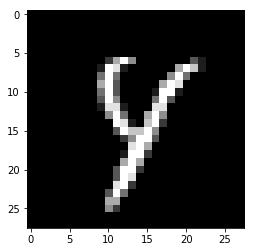

Bild Nr. 23
Richtiges Label 7
Knn Label Ergebnis: 9


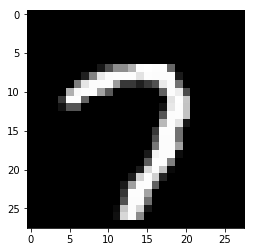

Bild Nr. 24
Richtiges Label 5
Knn Label Ergebnis: 8


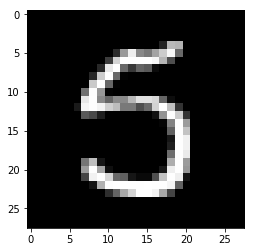

Bild Nr. 25
Richtiges Label 3
Knn Label Ergebnis: 5


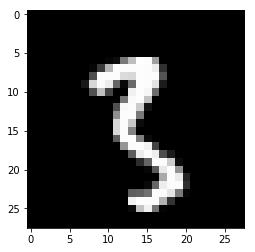

Bild Nr. 26
Richtiges Label 5
Knn Label Ergebnis: 9


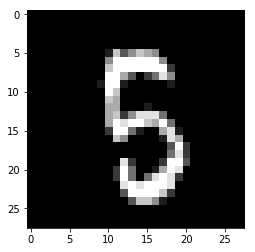

Bild Nr. 27
Richtiges Label 0
Knn Label Ergebnis: 9


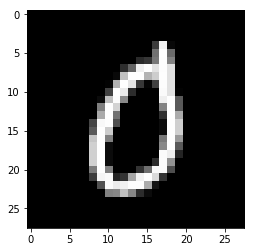

Bild Nr. 28
Richtiges Label 5
Knn Label Ergebnis: 3


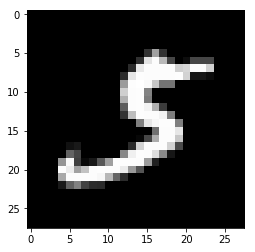

Bild Nr. 29
Richtiges Label 8
Knn Label Ergebnis: 3


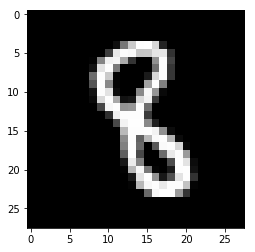

Bild Nr. 30
Richtiges Label 3
Knn Label Ergebnis: 2


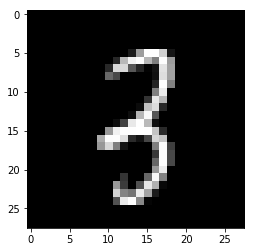

Bild Nr. 31
Richtiges Label 3
Knn Label Ergebnis: 5


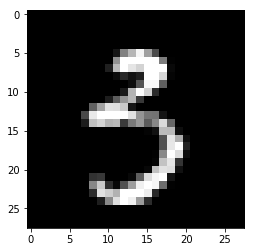

Bild Nr. 32
Richtiges Label 3
Knn Label Ergebnis: 2


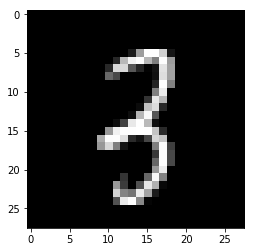

Bild Nr. 33
Richtiges Label 6
Knn Label Ergebnis: 5


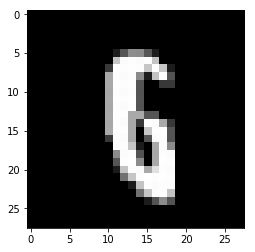

Bild Nr. 34
Richtiges Label 8
Knn Label Ergebnis: 5


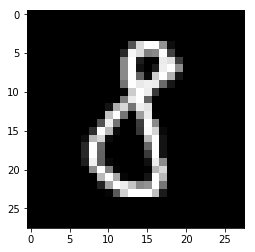

Bild Nr. 35
Richtiges Label 9
Knn Label Ergebnis: 8


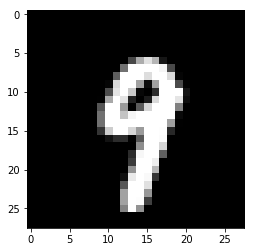

Bild Nr. 36
Richtiges Label 3
Knn Label Ergebnis: 8


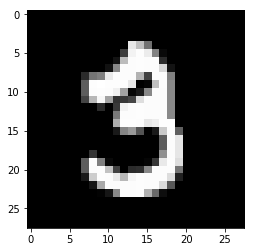

Bild Nr. 37
Richtiges Label 4
Knn Label Ergebnis: 9


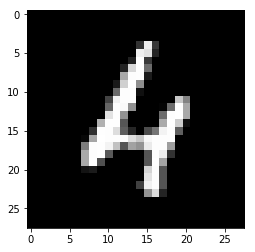

Bild Nr. 38
Richtiges Label 8
Knn Label Ergebnis: 9


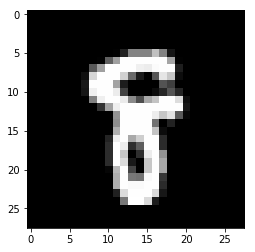

Bild Nr. 39
Richtiges Label 2
Knn Label Ergebnis: 7


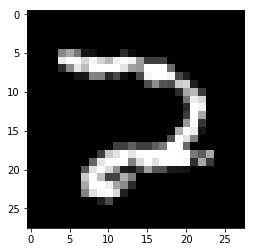

Bild Nr. 40
Richtiges Label 2
Knn Label Ergebnis: 9


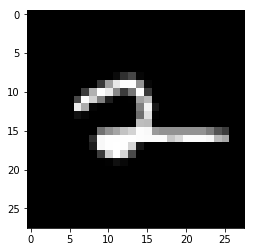

Bild Nr. 41
Richtiges Label 9
Knn Label Ergebnis: 0


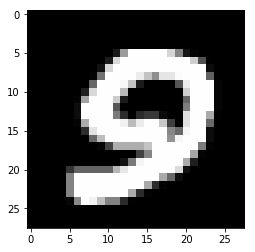

Bild Nr. 42
Richtiges Label 5
Knn Label Ergebnis: 6


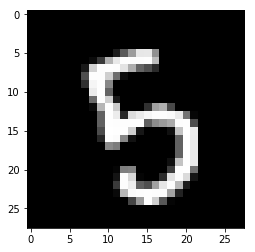

Bild Nr. 43
Richtiges Label 6
Knn Label Ergebnis: 8


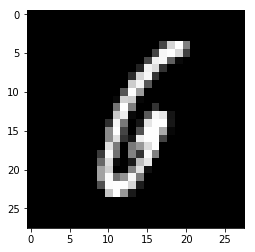

Confusion matrix, without normalization
[[27  0  0  0  0  0  0  0  0  3]
 [ 0 34  0  1  0  0  0  0  0  0]
 [ 0  0 20  1  0  0  0  2  2  1]
 [ 0  0  3 27  0  2  0  0  1  0]
 [ 0  0  0  0 26  1  0  0  0  2]
 [ 0  0  0  1  0 27  1  0  4  1]
 [ 0  0  0  1  1  1 30  0  1  0]
 [ 0  0  0  0  0  0  0 27  0  4]
 [ 0  0  0  1  0  1  1  0 20  2]
 [ 1  0  0  0  1  0  0  1  1 19]]


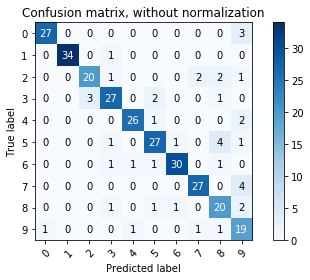

In [0]:
logReg_result = logReg("lbfgs")
calc_error(logReg_result)

# **Antwort**
**What is the error rate of KNN on the test set and what is the error rate for each label (number)?**

Ergebnis mit Solver = sag

Errorrate:  11.333333333333332 %

F1 Score:  0.8866666666666667

Errorrate durch F1 überprüfen:  0.11333333333333329

```
Errorrate für 0  =  3.33 %
Errorrate für 1  =  2.86 %
Errorrate für 2  =  26.92 %
Errorrate für 3  =  18.18 %
Errorrate für 4  =  3.45 %
Errorrate für 5  =  14.71 %
Errorrate für 6  =  11.76 %
Errorrate für 7  =  3.23 %
Errorrate für 8  =  16.0 %
Errorrate für 9  =  17.39 %
```
----
Ergebnis mit Solver = saga

Errorrate:  11.666666666666666 %

F1 Score:  0.8833333333333333

Errorrate durch F1 überprüfen:  0.1166666666666667
```
Errorrate für 0  =  3.33 %
Errorrate für 1  =  2.86 %
Errorrate für 2  =  30.77 %
Errorrate für 3  =  15.15 %
Errorrate für 4  =  3.45 %
Errorrate für 5  =  14.71 %
Errorrate für 6  =  11.76 %
Errorrate für 7  =  3.23 %
Errorrate für 8  =  20.0 %
Errorrate für 9  =  17.39 %
```
---

Ergebnis mit Solver = liblinear (default)

Errorrate:  14.333333333333334 %

F1 Score:  0.8566666666666667

Errorrate durch F1 überprüfen:  0.1433333333333333
```
Errorrate für 0  =  10.0 %
Errorrate für 1  =  2.86 %
Errorrate für 2  =  34.62 %
Errorrate für 3  =  18.18 %
Errorrate für 4  =  10.34 %
Errorrate für 5  =  14.71 %
Errorrate für 6  =  8.82 %
Errorrate für 7  =  12.9 %
Errorrate für 8  =  20.0 %
Errorrate für 9  =  17.39 %
```
---
---
**How does the choice of k influence the results?** -> How does the choice of the solver influence the results?

Die Logistic Regression hat mit dem solver SAG die besten Ergebnisse geliefert. Hier wurde eine Errorrate von insgesamt 11.4% erreicht. SAGA hat ebenfalls gute Ergebnisse geliefert und hat eine 0.3% höhere Errorrate. Der default Solver liblinear lieferte die schlechtesten Ergebnisse.
An die 4.17% von KNN konnte die Logistic Regression in keinem Durchlauf rankommen. 

---
---

**Some numbers are more difficult to predict with KNN and to cluster with
K-means. Show why. Start with examples, and get more general**

Schauen wir uns das Ergebnis vom Solver SAG an.

Beispielsweise Bild Nr.9 zeigt eine 9, unsere Prediction war 4. Hier handelt es sich um einen Sonderfall wie die Zahl geschrieben wurde. 

Das selbe gilt bei Bild Nr.2, hier ist noch zusätzlich Rauschen im Bild, die unsere Zahl in der Regression eher der 7 zuordnen.

Oder in den Bildern Nr.1-4 sieht man Extremfälle die nicht häufig im Trainingset zu finden sind. Die Zahlen sind daher Ausreißer, die nicht auf unseren normalen Regression liegen und somit vom Algorithmus falsch eingestuft werden.

Wenn man durch die verschiedenen falsch eingestufenten Bilder scrollt, sieht man, dass die Mehrheit Sonderfälle abbilden. Diese Ausreißer kann die Logistic Regression schwer richtig einstufen.